In [1]:
import torch
import numpy as np
import onnx
import onnxruntime
import os
import WDNet
import matplotlib.pyplot as plt
import torchvision
from PIL import Image
import torchvision.transforms as transforms 

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()


def pil_resize_for_kernel(img_path,kernel_size=16):
    with Image.open(img_path) as pil_img:
        src_img_size = pil_img.size
        new_w = (src_img_size[0]//kernel_size + 1)*kernel_size if src_img_size[0]%kernel_size != 0 else src_img_size[0]
        new_h = (src_img_size[1]//kernel_size + 1)*kernel_size if src_img_size[1]%kernel_size != 0 else src_img_size[1]
        if (new_w != src_img_size[0]) or (new_h != src_img_size[1]):
            return (pil_img.resize((new_w,new_h)), src_img_size)
        else:
            return (pil_img, src_img_size)

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
model_path = '../../YandexDisk/ML_models/model_WDNet/2024-04-16_mydsv2-2' # local drive
device = 'cpu'

In [2]:
#load torch model
torch_model = WDNet.generator(3,3)
torch_model.load_state_dict(torch.load(os.path.join(model_path,'WDNet_G.pkl')))
torch_model.eval()
torch_model.to(device)
print('torch model loaded')

torch model loaded


In [3]:
#export onnx model
rnd_inp = torch.randn(1, 3, 16, 16, requires_grad=True) # 16x16 - min image size to go through WDNet
onnx_path = os.path.join(model_path,'WDnet_G.onnx')

#dynamic axes in order to make model compatitable with different image sizes
dynamic_axes = {
    'input':  {2:"img_w",3:"img_h"},
    'output': {2:"img_w",3:"img_h"}
}

dynamic_axes = {
    'input':  [2,3],
    'output': [2,3]
}

torch.onnx.export(torch_model,rnd_inp,onnx_path,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes=dynamic_axes)

#load onnx model
onnx_model = onnx.load(onnx_path)
onnx.checker.check_model(onnx_model)
print('\nonnx model checekd')

c:\Programs\anaconda3\Lib\site-packages\torch\onnx\utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input input
  warnings.warn(
c:\Programs\anaconda3\Lib\site-packages\torch\onnx\utils.py:2082: UserWarning: No names were found for specified dynamic axes of provided input.Automatically generated names will be applied to each dynamic axes of input output
  warnings.warn(
d:\GitHub\pet_WDNet\unet_parts.py:57: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
d:\GitHub\pet_WDNet\unet_parts.py:58: TracerWarning: torch.tensor results are registered as constants in the trace. Yo


onnx model checekd


In [5]:
#read with torch
torch_img_path = os.path.join('test_img','mona_lisa.jpg')
torch_img = torchvision.io.read_image(torch_img_path) #chw
print('torch_img:',torch_img.shape)

#read with PIL, resize, convert to tensor
pil_img_path = os.path.join('test_img','mona_lisa.jpg')
resized_pil, src_size = pil_resize_for_kernel(pil_img_path)
transform = transforms.Compose([ 
    transforms.PILToTensor() 
]) 
pil_tensor = transform(resized_pil)

print('reized_img:',pil_tensor.shape)
print(f'src_size: {src_size}')

torch_img: torch.Size([3, 440, 660])
reized_img: torch.Size([3, 448, 672])
src_size: (660, 440)


In [6]:
#pick-up test image
#test_img_path = os.path.join('test_img','wm2_16.jpg')
#test_img = torchvision.io.read_image(test_img_path)

test_img = pil_tensor
test_img = test_img.float() / 255
test_img = test_img.unsqueeze(0)
test_img = test_img.to(device)
test_img_numpy = to_numpy(test_img)
print(f'torch shape: {test_img.shape}')
print(f'numpy shape: {test_img_numpy.shape}')
print(f'device: {device}')

torch shape: torch.Size([1, 3, 448, 672])
numpy shape: (1, 3, 448, 672)
device: cpu


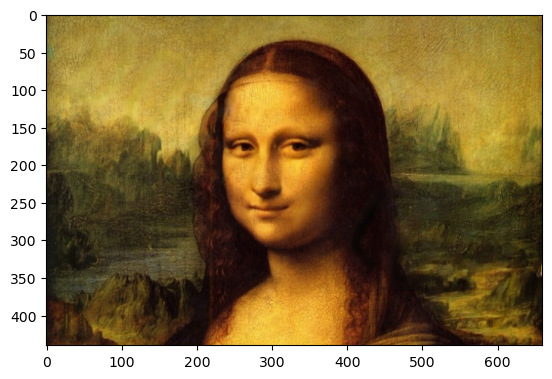

In [7]:
# torch
with torch.no_grad():
    torch_out = torch_model(test_img)
pil_image = torchvision.transforms.functional.to_pil_image(torch_out[0].squeeze(0))
pil_image = pil_image.resize(src_size)
plt.imshow(pil_image)

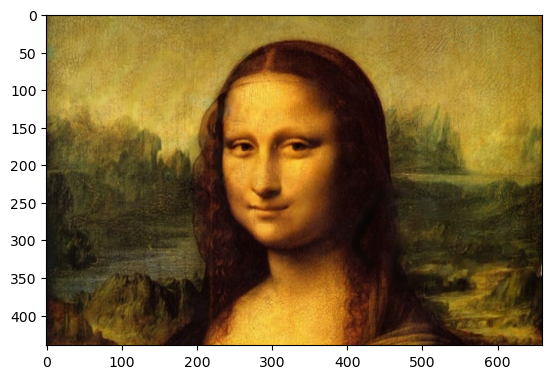

In [8]:
ort_session = onnxruntime.InferenceSession(onnx_path, providers=["CPUExecutionProvider"])
ort_inputs = {ort_session.get_inputs()[0].name: test_img_numpy}
onnx_out = ort_session.run(None, ort_inputs)

# bad way to show image 
onnx_torch = torch.from_numpy(onnx_out[0]).squeeze(0)
pil_image = torchvision.transforms.functional.to_pil_image(onnx_torch)
pil_image = pil_image.resize(src_size)
plt.imshow(pil_image)

In [87]:
with torch.no_grad():
    for i in range(10):
        torch_out = torch_model(test_img)

In [88]:
for i in range(10):
    onnx_out = ort_session.run(None, ort_inputs)

In [66]:
#something rong with numpy-image conversion
from PIL import Image

np_img = np.rint(onnx_out[0]*255).squeeze() #CHW
np_img = np.transpose(np_img, axes=[1,2,0]) #HWC
np_img.shape

onnx_image = Image.fromarray(np_img,mode='RGB')
plt.imshow(onnx_image)

TypeError: Cannot handle this data type: (1, 1, 3), <f4